In [1]:
import numpy as np
import pandas as pd
from pandas import Timedelta
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from scipy import signal
%matplotlib inline

# If you want a style choose one
plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'

In [2]:
# Preparing the final DataFrame
df = pd.read_csv(r'data\Merge_all_prices_load_gen_res.csv')

In [3]:
df.isna().sum()

date                    0
year                    0
month                   0
day                     0
dayofyear               0
hour                    0
week                    0
dayofweek               0
price                   0
period_start_utc        0
period_end_utc          0
c_by_hour               0
load_forecast_da     1107
load_actual             9
off_wind_da             0
off_wind_act            0
on_wind_da              3
on_wind_act            48
solar_da                3
solar_act              48
gen_forecast_da     32738
gen_actual              0
res_sum_da              0
res_sum_act             0
dtype: int64

In [5]:
# Dealing with missing values in exogenous variables
df_total['solar_da'] = df_total['solar_da'].fillna(0)
df_total['on_wind_da'] = df_total['on_wind_da'].interpolate(method='linear')

In [6]:
df_dec = df_total[df_total['timestamp_utc'] >= '2025-12-01T00:00']
df_dec.set_index('timestamp_utc', inplace=True)
df_dec.index = pd.to_datetime(df_dec.index)

Text(0.5, 1.0, 'Day-Ahead Energy Prices in December 2025')

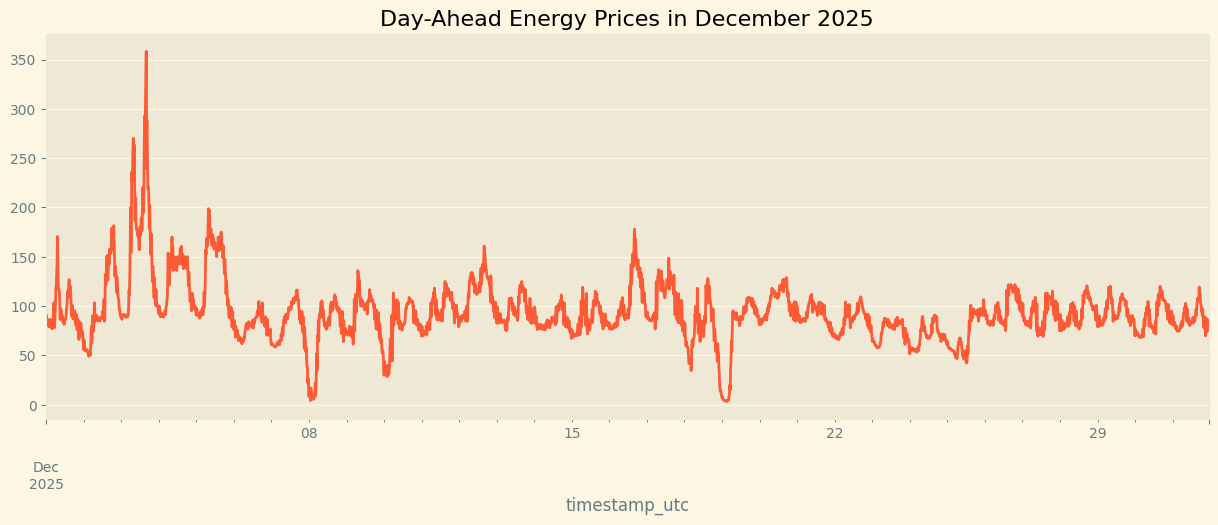

In [7]:
df_dec['price'].plot(figsize=(15, 5), color=NF_ORANGE)
plt.title('Day-Ahead Energy Prices in December 2025')

## SARIMAX ##

The parameters are split into Non-Seasonal (short-term) and Seasonal (long-term cycle) components (p, d, q) and (P, D, Q, s).
<p>1. Non-Seasonal Order: (p, d, q)
<p>Example setting: (2, 0, 2)</p>
<p>p = 2 (Autoregressive - AR):</p> 
<p>The model looks back 2 time steps (e.g., 2 hours). It assumes the current value is a linear combination of the last two values.</p>
<p>d = 0 (Integrated - I): This is the "differencing" term used to make data stationary. Setting this to 0 means your data is already stable (doesn't have a constant upward/downward trend) and doesn't need to be subtracted from itself.</p>
<p>q = 2 (Moving Average - MA): The model looks at the error (the gap between prediction and reality) of the last 2 time steps. It uses these past mistakes to smooth out current predictions.</p>
<p>2. Seasonal Order: (P, D, Q, s)</p>
<p>Example setting: (1, 0, 1, 24)</p>
<p>This handles the repeating patterns (like how electricity prices usually peak at the same time every day).</p>
<p>P = 1 (Seasonal AR): The model looks back at the value from exactly one season ago. If $s=24$, it looks at the value from 24 hours ago.</p>
<p>D = 0 (Seasonal I): Similar to the non-seasonal $d$, this means you aren't differencing the data across seasons.</p>
<p>Q = 1 (Seasonal MA): The model looks at the prediction error from one season ago (24 hours ago) to adjust the current forecast.</p>
<p>s = 24 (Seasonal Period): This defines the length of one full cycle. Since you are likely working with hourly data, 24 tells the model that the pattern repeats every day.</p>

In [8]:
# Ensure timestamp index
df_total["timestamp_utc"] = pd.to_datetime(df_total["timestamp_utc"])
df_total = df_total.set_index("timestamp_utc").sort_index()

In [9]:
# Resample to hourly
df_total = df_total.drop('MTU (CET/CEST)', axis =1)
df_total = df_total.resample('H').mean()
df_total = df_total.asfreq("H")
print(df_total.isna().sum())

price               0
load_actual         0
load_forecast_da    0
off_wind_da         0
off_wind_act        0
on_wind_da          0
on_wind_act         0
solar_da            0
solar_act           0
gen_forecast_da     0
gen_actual          0
dtype: int64


In [10]:
# Target
y = df_total["price"]

# Exogenous variables
exog = df_total[["load_forecast_da", "off_wind_da", "on_wind_da", "solar_da"]]

In [11]:
exog.isna().sum()

load_forecast_da    0
off_wind_da         0
on_wind_da          0
solar_da            0
dtype: int64

In [12]:
# print(f"Rows before: {len(df_total)}")
# df_total = df_total.asfreq("H")
# print(f"Rows after: {len(df_total)}")

In [ ]:
# Train / test split
#split_point = "2025-12-01 00:00:00"
#begin_point = "2025-11-25 00:00:00"
#end_point = "2025-12-05 23:00:00"

#y_train = y[:split_date]
#y_train = y[:pd.to_datetime(split_point) - Timedelta(days=1)]
#y_test  = y[split_point:]

#exog_train = exog[:pd.to_datetime(split_point) - Timedelta(days=1)]
#exog_test  = exog[split_point:]


In [37]:
# Define the exact point where training ends and testing begins
split_point = "2025-11-30 23:00:00" # Or whatever your last train hour is

y_train = y[:split_point]
exog_train = exog[:split_point]

# Use a slice that starts immediately after
y_test = y[split_point:].iloc[1:] 
exog_test = exog[split_point:].iloc[1:]

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the frequency explicitly
#y_train = y_train.asfreq('15T')
#exog_train = exog_train.asfreq('15T')

# Now run the SARIMAX model

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                 8017
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -30910.805
Date:                            Fri, 06 Feb 2026   AIC                          61839.610
Time:                                    16:17:18   BIC                          61902.485
Sample:                                12-31-2024   HQIC                         61861.133
                                     - 11-30-2025                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
load_forecast_da     0.0030    3.1e-05     97.846      0.000       0.003       0.003
off_wind_da      

Text(0.5, 1.0, 'SARIMAX Forecast of Day-Ahead Energy Prices (Next 24 Hours)')

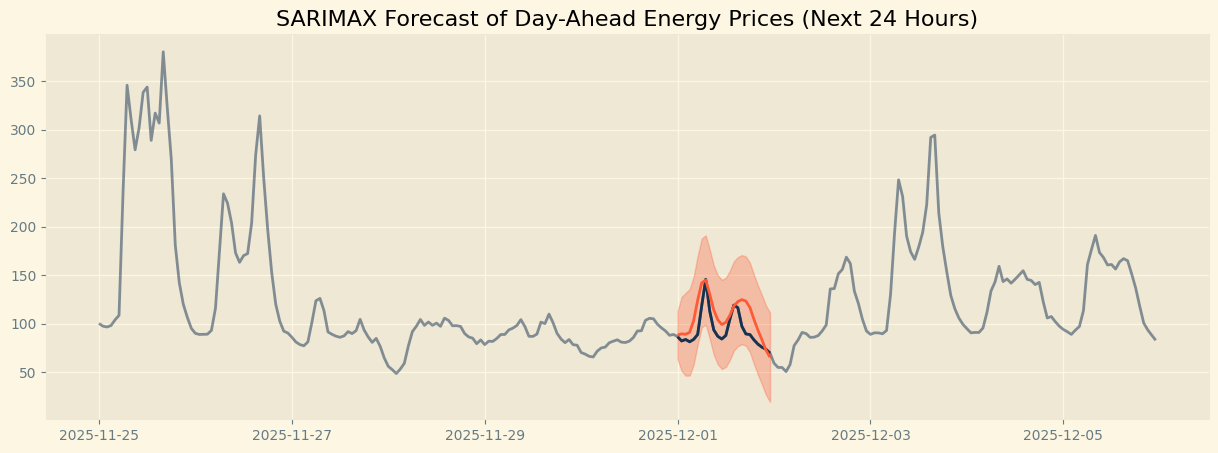

In [47]:
# Forecast next-day hourly prices

n_steps = 24

forecast = results.get_forecast(
    steps=n_steps,
    exog=exog_test.iloc[:n_steps]
)

y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plotting actual curne and the results

actual_values = y_test.loc[y_pred.index]

plt.figure(figsize=(15, 5))
plt.plot(y_slice.index, y_slice, label='Historical', color=NF_BLUE, alpha=0.5)
#plt.plot(y_test.index[:n_steps], y_test[:n_steps], label='Actual', color=NF_BLUE)
plt.plot(actual_values.index, actual_values, label='Actual', color=NF_BLUE)
plt.plot(y_pred.index, y_pred, label='Predicted', color=NF_ORANGE)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=NF_ORANGE, alpha=0.3, label='Confidence Interval')
plt.title('SARIMAX Forecast of Day-Ahead Energy Prices (Next 24 Hours)')